### Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
!pip install Korpora

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install python-mecab-ko

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.9/573.9 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 14.8 MB/s eta 0:00:00


In [ ]:
#import package
from Korpora import Korpora
import pandas as pd
import gensim as gn
import numpy as np
from collections import Counter
from mecab import MeCab
import nltk
import numpy as np
import tensorflow as tf
import os

### Data Preview

In [ ]:
corpus = Korpora.load("nsmc")

In [ ]:
print(corpus.train[0],corpus.train[0].text , corpus.train[0].label)

LabeledSentence(text='아 더빙.. 진짜 짜증나네요 목소리', label=0) 아 더빙.. 진짜 짜증나네요 목소리 0


In [ ]:
print(corpus.test[0],corpus.test[0].text , corpus.test[0].label)

LabeledSentence(text='굳 ㅋ', label=1) 굳 ㅋ 1


In [ ]:
print(corpus.train, corpus.test) 

NSMC.train: size=150000
  - NSMC.train.texts : list[str]
  - NSMC.train.labels : list[int]
 NSMC.test: size=50000
  - NSMC.test.texts : list[str]
  - NSMC.test.labels : list[int]



In [ ]:
df_train = pd.DataFrame(corpus.train)
df_test = pd.DataFrame(corpus.test)

In [ ]:
df_train.head()

,text,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
df_train.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
print(df_train['text'].nunique(dropna = False), len(df_train['text'])) 

146183 150000


In [ ]:
print(df_test['text'].nunique(dropna = False), len(df_test['text'])) 

49158 50000


In [ ]:
df_train.drop_duplicates('text',inplace = True)
df_test.drop_duplicates('text',inplace = True)

In [ ]:
print(df_train.shape, df_test.shape) 

(146183, 2) (49158, 2)


In [ ]:
stop_words = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def token_generator(data, stop_words = stop_words):
  token_list = []
  for x in data:
    word_tokens = okt.morphs(x)
    result = [word for word in word_tokens if not word in stop_words]
    for x in result:
      if x in token_list:
        continue
      else:
        token_list.append(x)
  word_index = {'<PAD>': 0, '<BOS>': 1, '<UNK>': 2}
  for (x,y) in enumerate(token_list):
    word_index[y] = x+3
  return word_index

In [ ]:
token_list = token_generator(df_train['text'][0:3])

In [ ]:
df_train['text'][0]

'아 더빙.. 진짜 짜증나네요 목소리'

### Encoded and Decoded

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('아 더빙.. 진짜 짜증나네요 목소리', token_list))

[1, 3, 2, 6, 7, 8]


In [ ]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(df_train['text'][0:3], token_list)
print(encoded_sentences)

[[1, 3, 2, 6, 7, 8], [1, 2, 2, 20, 21], [1, 2]]


In [ ]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    index_to_word= dict(map(reversed,index_to_word.items()))
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 2, 6, 7, 8], token_list))

아 <UNK> 진짜 짜증나네요 목소리


In [ ]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, token_list))

['아 <UNK> 진짜 짜증나네요 목소리', '<UNK> <UNK> 가볍지 않구나', '<UNK>']


In [ ]:
encoded_sentences

[[1, 3, 2, 6, 7, 8], [1, 2, 2, 20, 21], [1, 2]]

### Model_Class

In [ ]:
class NLP_basic():
  def __init__(self,stopwords ,corpus = 'korea', data = False):
    self.corpus = 'korea'
    self.data = data
    self.stopwords = stopwords

  def data_loader(self):
    if self.corpus == 'korea':
      corpus_kr = Korpora.load("nsmc")
      df_train = pd.DataFrame(corpus_kr.train)
      df_test = pd.DataFrame(corpus_kr.test)
      df_train.drop_duplicates('text',inplace = True)
      df_test.drop_duplicates('text',inplace = True)
    elif self.data == True:
      pass
    return pd.DataFrame(df_train['text']),pd.DataFrame(df_train['label']), pd.DataFrame(df_test['text']),pd.DataFrame(df_test['label']) 

  def token_generator(self, data, stop_words = stop_words):
    token_list = []
    for x in data:
      word_tokens = okt.morphs(x)
      result = [word for word in word_tokens if not word in stop_words]
      for x in result:
        if x in token_list:
          continue
        else:
          token_list.append(x)
    word_index = {'<PAD>': 0, '<BOS>': 1, '<UNK>': 2}
    for (x,y) in enumerate(token_list):
      word_index[y] = x+3
    return word_index

  def get_encoded_sentence(self, sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

  def get_encoded_sentences(self, sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

  def get_decoded_sentence(self, encoded_sentence, index_to_word):
    index_to_word= dict(map(reversed,index_to_word.items()))
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

  def get_decoded_sentences(self, encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
sample = NLP_basic(stop_words,'korea')

In [ ]:
train_x, train_y, test_x,test_y = sample.data_loader()


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/

[Korpora] Corpus `nsmc` is already installed at /root/Korpora/nsmc/ratings_train.txt
[Korpora] Corpus `nsmc` is already installed at /root/Korpora/nsmc/ra

In [ ]:
word_index = sample.token_generator(train_x['text'])

In [ ]:
word_index

In [ ]:
import pickle
# save data
with open('word_index.pickle','wb') as fw:
    pickle.dump(word_index, fw)

#### Keras embdiing and validation split

In [ ]:
vocab_size = len(word_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
raw_inputs = np.array(sample.get_encoded_sentences(train_x['text'], word_index), dtype=object)
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[-0.04773861 -0.01777637  0.0318606   0.04971198]
  [ 0.0391568   0.01938058 -0.01124437 -0.04702912]
  [ 0.00704131 -0.01773703 -0.04671691  0.0391531 ]
  [ 0.03510592 -0.04320742 -0.02118049 -0.00255209]
  [-0.04326541 -0.01897737  0.04866428  0.00235172]]

 [[-0.02202872  0.04260578  0.00553539 -0.00933695]
  [ 0.0391568   0.01938058 -0.01124437 -0.04702912]
  [ 0.0391568   0.01938058 -0.01124437 -0.04702912]
  [ 0.00919538  0.04797435  0.00017829  0.03703303]
  [-0.02827123  0.02305498 -0.00133778  0.00092499]]

 [[-0.02202872  0.04260578  0.00553539 -0.00933695]
  [ 0.0391568   0.01938058 -0.01124437 -0.04702912]
  [-0.04131794 -0.00860566 -0.01768625 -0.01622235]
  [-0.04131794 -0.00860566 -0.01768625 -0.01622235]
  [-0.04131794 -0.00860566 -0.01768625 -0.01622235]]

 ...

 [[ 0.0391568   0.01938058 -0.01124437 -0.04702912]
  [ 0.0391568   0.01938058 -0.01124437 -0.04702912]
  [-0.04376893  0.04123378 -0.01971902 -0.01853857]
  [ 0.0391568   0.01938058 -0.01124437 -0

In [ ]:
print(sample.get_encoded_sentence(train_x['text'][1500], word_index))

[1, 2, 178, 3702, 2, 44, 333, 2, 6351, 2]


In [ ]:
print(sample.get_decoded_sentence([1, 2, 178, 3702, 2, 44, 333, 2, 6351, 2], word_index))

<UNK> 가장 좋아하는 <UNK> 스파이더맨 완전 <UNK> 영원했으면 <UNK>


In [ ]:
total_data_text = list(train_x['text']) + list(test_x['text'])
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  35.983541601609495
문장길이 최대 :  158
문장길이 표준편차 :  29.572497312283254
pad_sequences maxlen :  95
전체 문장의 0.9337927009690746%가 maxlen 설정값 이내에 포함됩니다. 


In [ ]:
train_x_input = sample.get_encoded_sentences(train_x['text'], word_index)

In [ ]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(train_x_input,
                                                       value=word_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

In [ ]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = train_y[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = train_y[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136183, 95)
(136183, 1)


In [ ]:
x_test = sample.get_encoded_sentences(test_x['text'], word_index)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)
y_test = test_y['label']

### Various Model

#### Lstm

In [ ]:
vocab_size = len(word_index)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          1674608   
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,675,489
Trainable params: 1,675,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 50s 152ms/step - loss: 0.6104 - accuracy: 0.6575 - val_loss: 0.5277 - val_accuracy: 0.7104
Epoch 2/20
266/266 [==============================] - 10s 39ms/step - loss: 0.4780 - accuracy: 0.7523 - val_loss: 0.5147 - val_accuracy: 0.7262
Epoch 3/20
266/266 [==============================] - 6s 24ms/step - loss: 0.4262 - accuracy: 0.7813 - val_loss: 0.5224 - val_accuracy: 0.7245
Epoch 4/20
266/266 [==============================] - 4s 17ms/step - loss: 0.3938 - accuracy: 0.7968 - val_loss: 0.5454 - val_accuracy: 0.7252
Epoch 5/20
266/266 [==============================] - 5s 18ms/step - loss: 0.3727 - accuracy: 0.8055 - val_loss: 0.5602 - val_accuracy: 0.7188
Epoch 6/20
266/266 [==============================] - 6s 21ms/step - loss: 0.3592 - accuracy: 0.8119 - val_loss: 0.5797 - val_accuracy: 0.7154
Epoch 7/20
266/266 [==============================] - 4s 13ms/step - loss: 0.3504 - accuracy: 0.8145 - val_loss: 0.5915 - val_accuracy: 0.7

In [ ]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.7906 - accuracy: 0.6947 - 5s/epoch - 4ms/step
[0.7906045913696289, 0.6947190761566162]


In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


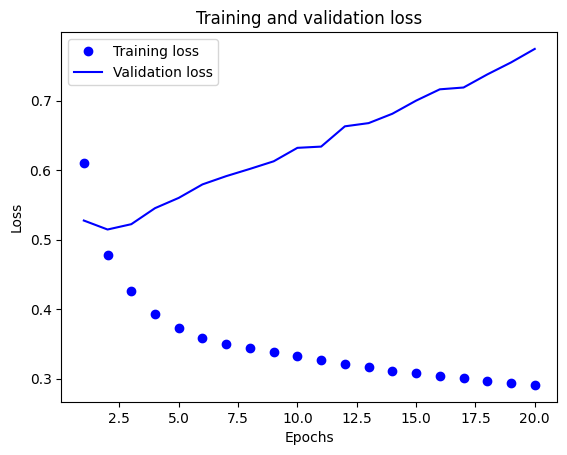

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

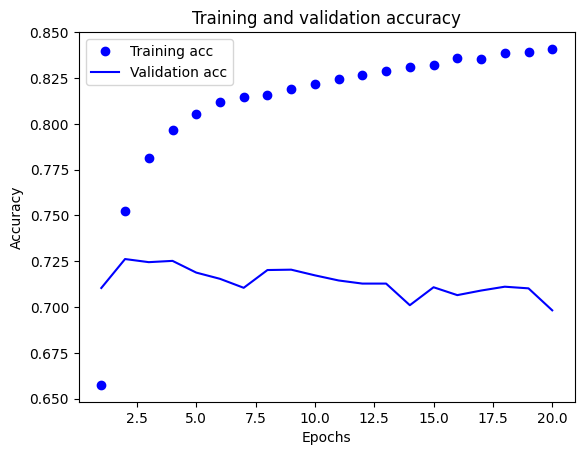

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 1D-conv

In [ ]:
vocab_size = len(word_index)  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 4)           418652    
                                                                 
 conv1d_6 (Conv1D)           (None, None, 16)          464       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 8)                

In [ ]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 36s 127ms/step - loss: 0.6827 - accuracy: 0.5361 - val_loss: 0.6462 - val_accuracy: 0.5909
Epoch 2/20
266/266 [==============================] - 9s 34ms/step - loss: 0.6132 - accuracy: 0.6200 - val_loss: 0.6256 - val_accuracy: 0.6000
Epoch 3/20
266/266 [==============================] - 7s 26ms/step - loss: 0.5723 - accuracy: 0.6472 - val_loss: 0.6326 - val_accuracy: 0.6061
Epoch 4/20
266/266 [==============================] - 4s 17ms/step - loss: 0.5449 - accuracy: 0.6629 - val_loss: 0.6470 - val_accuracy: 0.6076
Epoch 5/20
266/266 [==============================] - 5s 18ms/step - loss: 0.5266 - accuracy: 0.6719 - val_loss: 0.6666 - val_accuracy: 0.6023
Epoch 6/20
266/266 [==============================] - 4s 13ms/step - loss: 0.5148 - accuracy: 0.6763 - val_loss: 0.6840 - val_accuracy: 0.5906
Epoch 7/20
266/266 [==============================] - 3s 11ms/step - loss: 0.5062 - accuracy: 0.6797 - val_loss: 0.7001 - val_accuracy: 0.59

In [ ]:
results2 = model2.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8778 - accuracy: 0.5923 - 3s/epoch - 2ms/step
[0.7906045913696289, 0.6947190761566162]


In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


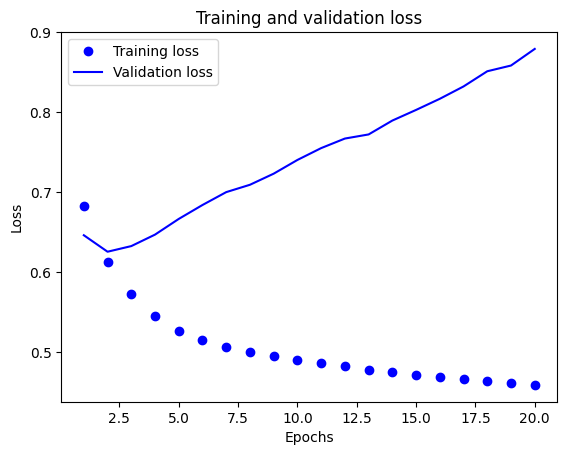

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

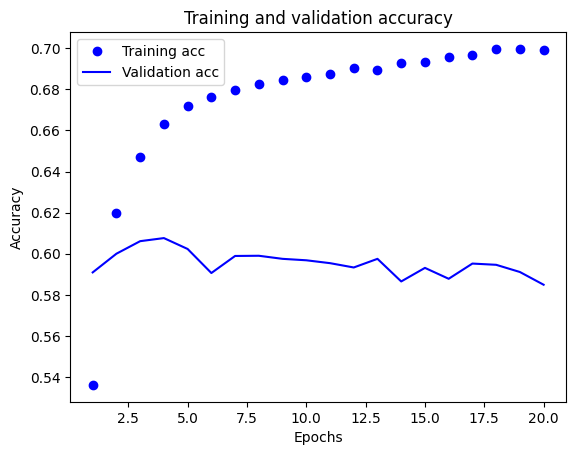

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
embedding_layer = model2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(104663, 4)


In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/AIFFEL/NLP_weights/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model2.get_weights()[0]
index_to_word= dict(map(reversed,word_index.items()))
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['짜증나네요']
vector

array([ 0.19151996,  0.17978083, -0.15521395,  0.10481862], dtype=float32)

In [ ]:
word_vectors.similar_by_word("짜증나네요")

[('재미없는거', 0.9999879598617554),
 ('라면서', 0.9999186992645264),
 ('싶지도', 0.999876081943512),
 ('넘어가야하는데', 0.9998241066932678),
 ('옹졸함과', 0.9997357726097107),
 ('하기', 0.9997307658195496),
 ('누르는데', 0.9997052550315857),
 ('난잡하긴', 0.9996486902236938),
 ('써있는데', 0.999631941318512),
 ('너무하잖아', 0.9996232390403748)]

# Using Korean Word2vec embedding and using third model
# 정확히 이유는 모르겠지만 코랩에서 kr word2vec weight가 안받아져서 다음 step은 아이펠 cloud jupyter를 사용해서 해결하였습니다.
# 갑작이 주피터 클라우드가 터져서 
# 해당 주피터 노트북 파일은 그냥 여기에 붙여넣기 하겠습니다.


### Wor2vec Kor ver

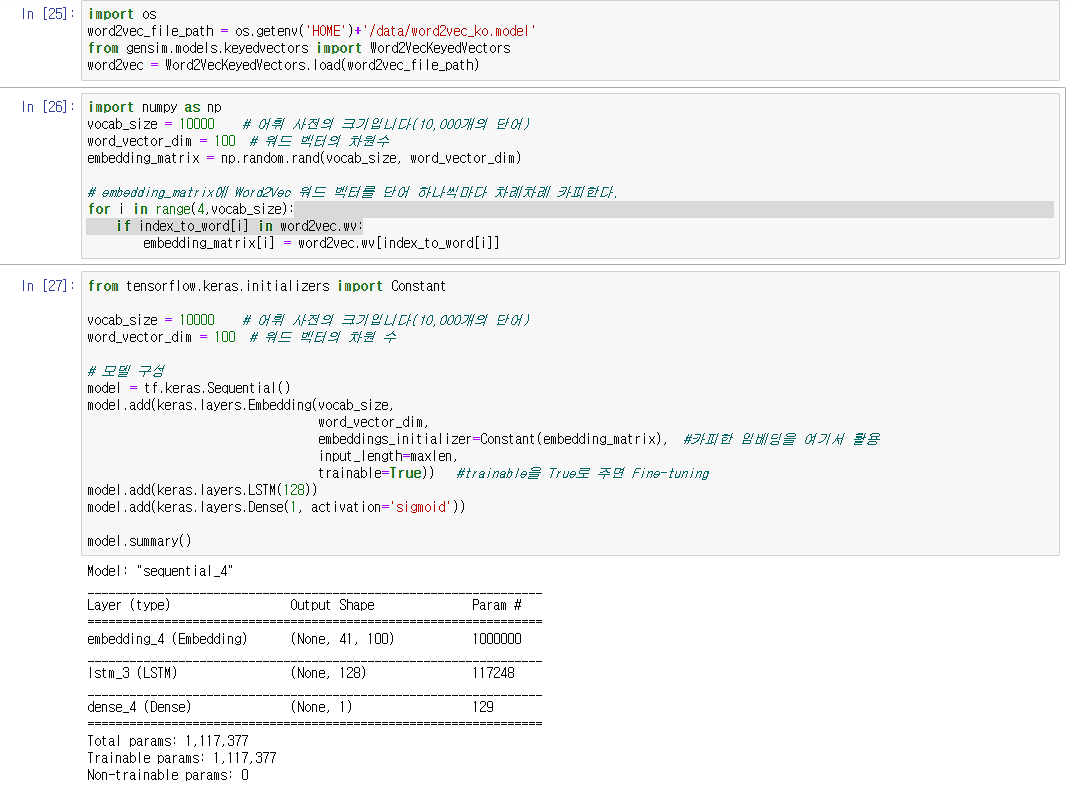

### Training with third model

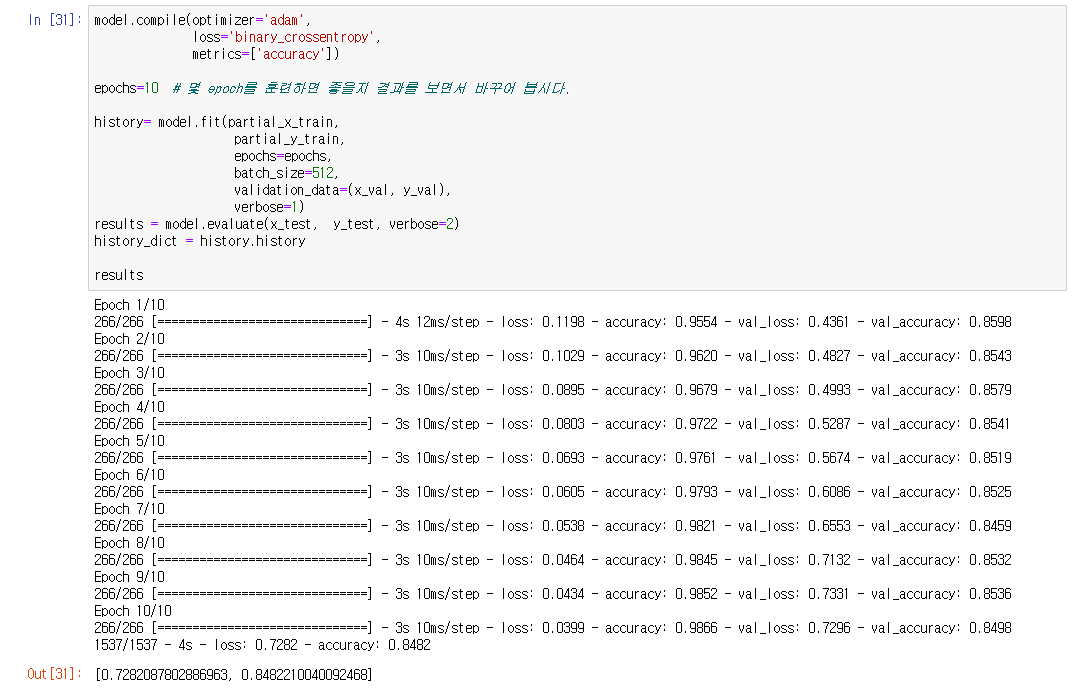

### Result and Accuracy

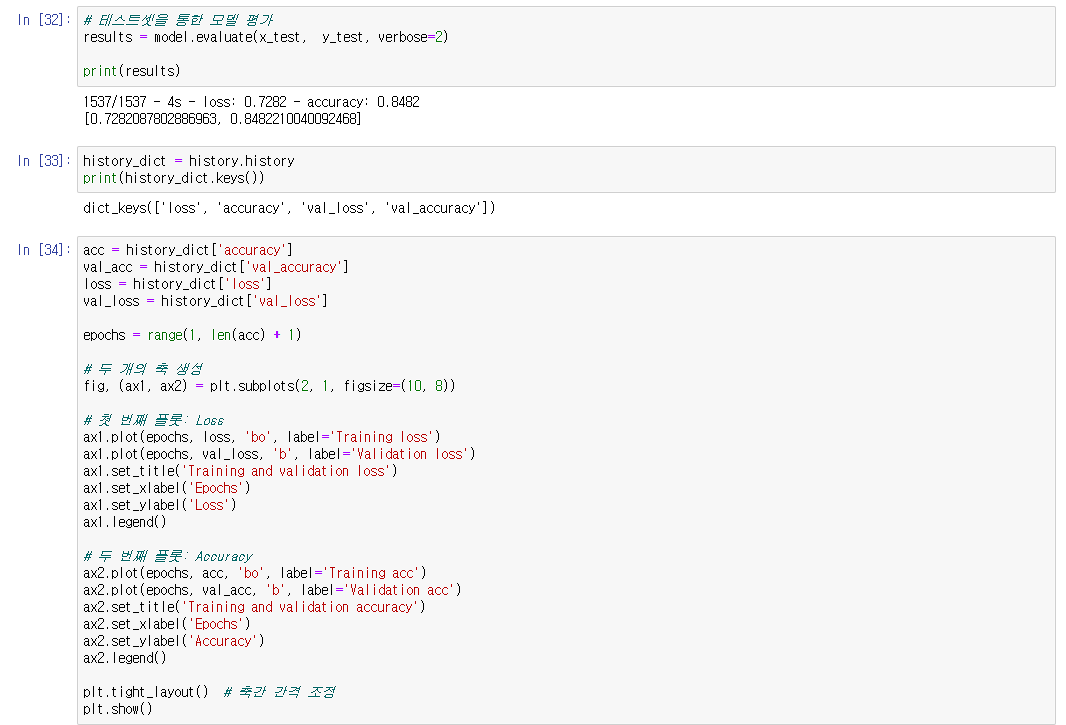

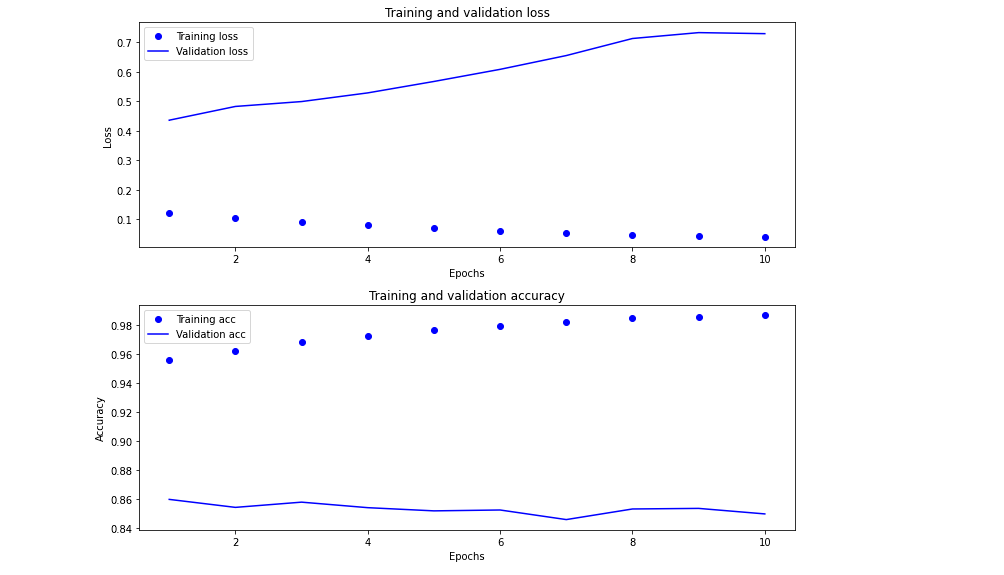